In [241]:
!nvidia-smi

Wed Mar  8 14:38:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   9019MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [242]:
import numpy as np
import random
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [243]:
EPOCHS = 500
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3

In [244]:
path= '/content/drive/MyDrive/PRCP-1001-RiceLeaf/Data/Bacterial leaf blight'

In [245]:
# plt.figure(figsize=(12,12))
# for i in range(1,41):
#     plt.subplot(10,4,i)
#     plt.tight_layout()
#     rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
#     plt.imshow(rand_img)
#     plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
#     plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [246]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [247]:
directory_root = '/content/drive/MyDrive/PRCP-1001-RiceLeaf/'
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Bacterial leaf blight ...
[INFO] Processing Leaf smut ...
[INFO] Processing Brown spot ...
[INFO] Image loading completed


In [248]:
image_size = len(image_list)
image_size

119

In [249]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [250]:
print(label_binarizer.classes_)

['Bacterial leaf blight' 'Brown spot' 'Leaf smut']


In [251]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [252]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [253]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [254]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [255]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_89 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_76 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 85, 85, 64)      

In [256]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [257]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-257-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
5/5 [==============================] - 3s 303ms/step - loss: 1.2955 - accuracy: 0.4937 - val_loss: 0.7513 - val_accuracy: 0.3750
Epoch 2/500
5/5 [==============================] - 1s 245ms/step - loss: 0.6486 - accuracy: 0.7089 - val_loss: 0.7684 - val_accuracy: 0.3750
Epoch 3/500
5/5 [==============================] - 1s 233ms/step - loss: 0.5584 - accuracy: 0.7342 - val_loss: 1.2459 - val_accuracy: 0.4167
Epoch 4/500
5/5 [==============================] - 2s 344ms/step - loss: 0.5162 - accuracy: 0.7342 - val_loss: 1.5060 - val_accuracy: 0.4167
Epoch 5/500
5/5 [==============================] - 2s 272ms/step - loss: 0.3781 - accuracy: 0.8101 - val_loss: 1.7071 - val_accuracy: 0.4167
Epoch 6/500
5/5 [==============================] - 1s 243ms/step - loss: 0.3542 - accuracy: 0.8375 - val_loss: 1.5333 - val_accuracy: 0.4167
Epoch 7/500
5/5 [==============================] - 1s 247ms/step - loss: 0.3418 - accuracy: 0.8250 - val_loss: 1.5590 - val_accuracy: 0.5833
Epoch 8/500
5

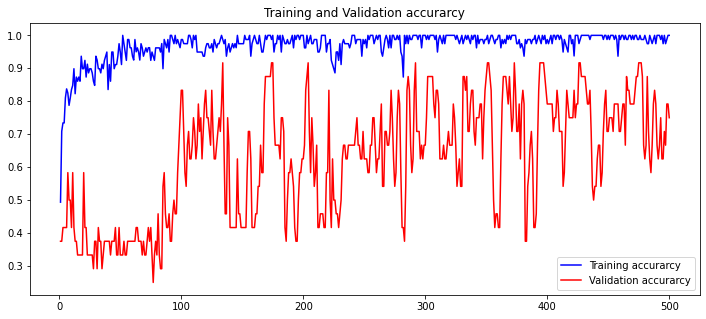

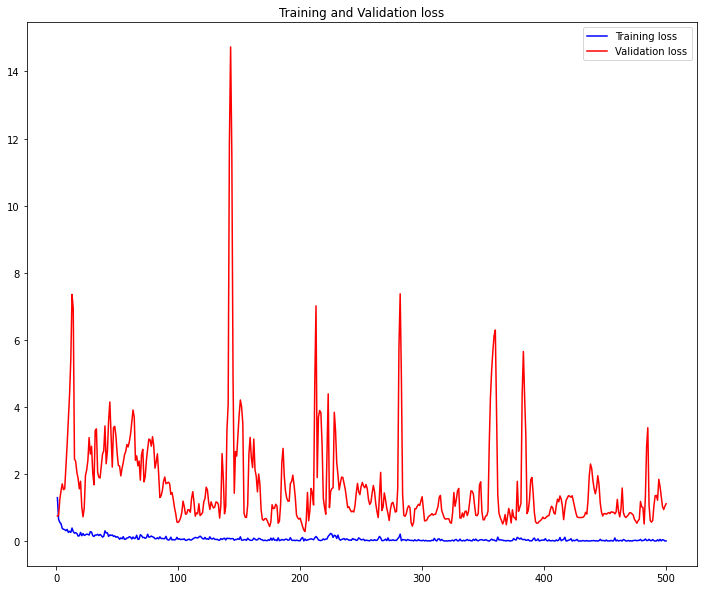

In [258]:
plt.figure(figsize=(12,5))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure(figsize=(12,10))
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [259]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1/1 [==============================] - 0s 58ms/step - loss: 1.1150 - accuracy: 0.7500
Test Accuracy: 75.0


In [260]:
image_dir='/content/drive/MyDrive/PRCP-1001-RiceLeaf/Data/Bacterial leaf blight'

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)